## **Titanic Survival Prediction**
---
**Author:** Prabhu Venkatesh Konda Radhakrishnan


In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

import seaborn as sns

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import math

from matplotlib import pyplot
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, roc_curve, plot_roc_curve, confusion_matrix, plot_confusion_matrix
from sklearn import tree

from IPython.display import Image, SVG
from graphviz import Source

### Load Data

In [2]:
ImportTitanicSurvival = sm.datasets.get_rdataset('TitanicSurvival', 'carData', cache = True)

print(ImportTitanicSurvival.__doc__)

=============== ===============
TitanicSurvival R Documentation
=============== ===============

Survival of Passengers on the Titanic
-------------------------------------

Description
~~~~~~~~~~~

Information on the survival status, sex, age, and passenger class of
1309 passengers in the Titanic disaster of 1912.

Usage
~~~~~

::

   TitanicSurvival

Format
~~~~~~

A data frame with 1309 observations on the following 4 variables.

``survived``
   ``no`` or ``yes``.

``sex``
   ``female`` or ``male``

``age``
   in years (and for some children, fractions of a year); age is missing
   for 263 of the passengers.

``passengerClass``
   ``1st``, ``2nd``, or ``3rd`` class.

Details
~~~~~~~

This is part of a larger data set compiled by Thomas Cason. Many
additional details are given in the sources cited below.

Source
~~~~~~

Data set ``titanic3`` from
http://biostat.mc.vanderbilt.edu/twiki/bin/view/Main/DataSets.

References
~~~~~~~~~~

http://www.encyclopedia-titanica.org/

F. E. Harrell

In [3]:
TitanicSurvival = ImportTitanicSurvival.data # place the data in bespoke variable

type(TitanicSurvival)

pandas.core.frame.DataFrame

In [4]:
TitanicSurvival.dtypes

survived           object
sex                object
age               float64
passengerClass     object
dtype: object

In [5]:
TitanicSurvival.head()

,survived,sex,age,passengerClass
"Allen, Miss. Elisabeth Walton",yes,female,29.0000,1st
"Allison, Master. Hudson Trevor",yes,male,0.9167,1st
"Allison, Miss. Helen Loraine",no,female,2.0000,1st
"Allison, Mr. Hudson Joshua Crei",no,male,30.0000,1st
"Allison, Mrs. Hudson J C (Bessi",no,female,25.0000,1st


### Descriptive Analysis

In [6]:
plotDat = (TitanicSurvival.
           assign(roundedAge = round(TitanicSurvival.age, -1)).
           groupby(['passengerClass', 'roundedAge', 'sex']).
           apply(lambda x: len(x.survived[x.survived == "yes"])/len(x.survived)).
           reset_index().
           rename(columns = {0: 'proportionSurvived'})
          )

In [7]:
plotDat.sample(5)

,passengerClass,roundedAge,sex,proportionSurvived
7,1st,30.0,male,0.407407
19,2nd,10.0,female,1.000000
36,3rd,20.0,female,0.548387
41,3rd,40.0,male,0.100000
1,1st,0.0,male,1.000000


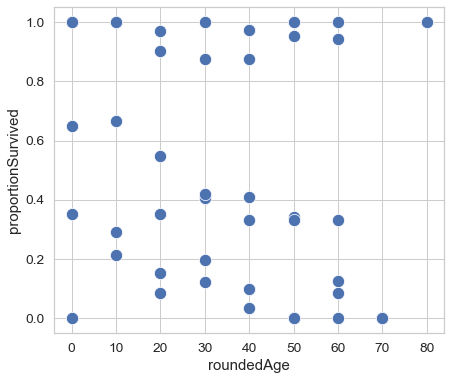

In [8]:
sns.set(rc = {'figure.figsize': (7, 6)},
        font_scale = 1.25) # increase text size on plots (e.g., axis labels)
sns.set_style('whitegrid')

sns.scatterplot(
    x = 'roundedAge',
    y = 'proportionSurvived',
    s = 150, # adjust point size
    data = plotDat)

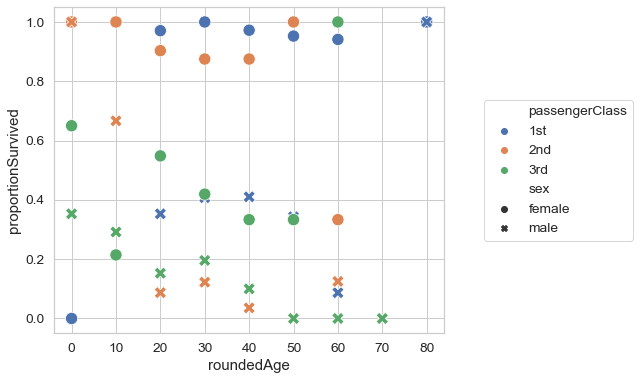

In [9]:
p = sns.scatterplot(
    x = 'roundedAge',
    y = 'proportionSurvived',
    s = 150,
    style = 'sex',
    hue = 'passengerClass',
    data = plotDat)

p.legend(loc = 'center right', bbox_to_anchor = (1.5, 0.5), ncol = 1) # move legend outside of plot

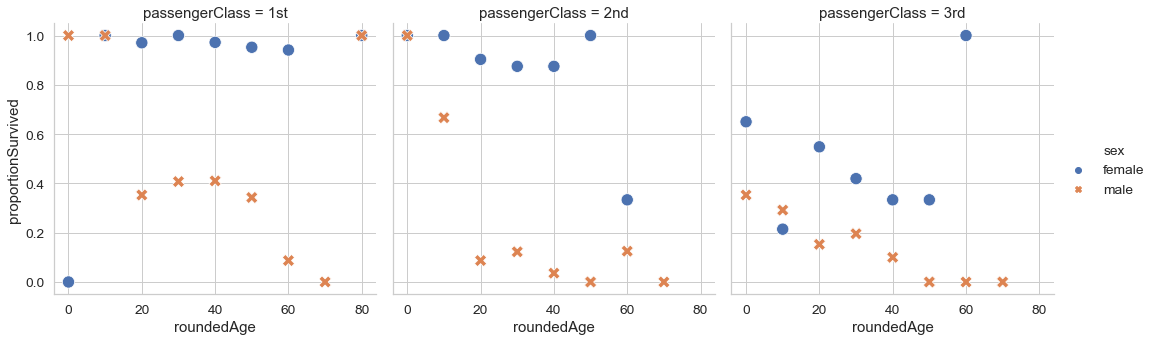

In [10]:
sns.relplot(
    x = 'roundedAge',
    y = 'proportionSurvived',
    s = 150,
    style = 'sex',
    hue = 'sex',
    col = 'passengerClass',
    kind = 'scatter',
    data = plotDat)

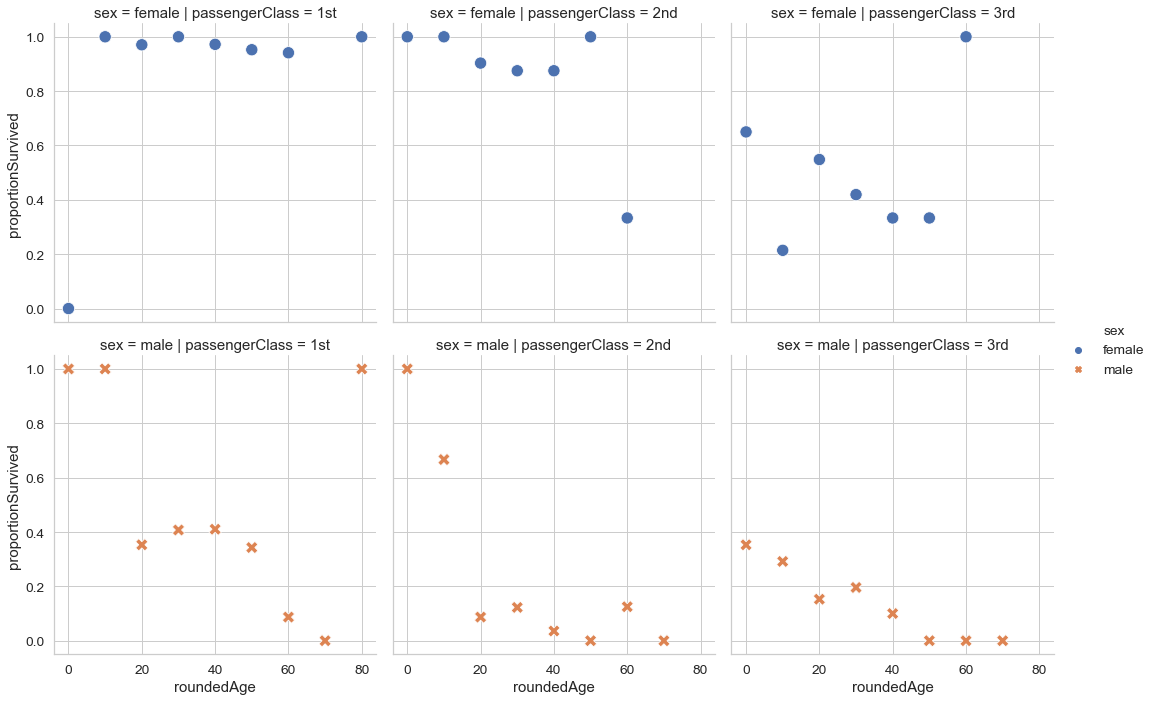

In [11]:
sns.relplot(
    x = 'roundedAge',
    y = 'proportionSurvived',
    s = 150,
    style = 'sex',
    hue = 'sex',
    col = 'passengerClass',
    row = 'sex',
    kind = 'scatter',
    data = plotDat)

## Logistic Regression

In [12]:
len(TitanicSurvival)

1309

In [13]:
len(TitanicSurvival.dropna())

1046

In [14]:
round(1 - len(TitanicSurvival.dropna())/len(TitanicSurvival), 3)

0.201

In [15]:
round(TitanicSurvival.isna().sum()/len(TitanicSurvival), 3)

survived          0.000
sex               0.000
age               0.201
passengerClass    0.000
dtype: float64

In [16]:
TitanicSurvivalNoNaNs = TitanicSurvival.dropna()

In [17]:
TitanicSurvivalNoNaNs.groupby('survived').size()

survived
no     619
yes    427
dtype: int64

In [18]:
# three main effects
mod1 = smf.glm(formula = 'survived ~ passengerClass + sex + age', data = TitanicSurvivalNoNaNs, family = sm.families.Binomial()).fit()

# all two-way interactions of these three main effects
mod2 = smf.glm(formula = 'survived ~ (passengerClass + sex + age) ** 2', data = TitanicSurvivalNoNaNs, family = sm.families.Binomial()).fit()

# full three-way interaction
mod3 = smf.glm(formula = 'survived ~ passengerClass * sex * age', data = TitanicSurvivalNoNaNs, family = sm.families.Binomial()).fit()

compare these three models:

In [19]:
models = pd.DataFrame({
    'models': ['mod1', 'mod2', 'mod3'],
    'df': [mod1.df_model, mod2.df_model, mod3.df_model],
    'AIC': [mod1.aic, mod2.aic, mod3.aic]
})

models['deltaAIC'] = models.AIC - min(models.AIC)

models.sort_values('AIC')

,models,df,AIC,deltaAIC
1,mod2,9,937.843246,0.000000
2,mod3,11,939.977104,2.133857
0,mod1,4,992.453105,54.609859


Among these three, mod2 looks the best based on AIC. term-level significance using a Wald test:

In [20]:
mod2.wald_test_terms() # equivalent to car::Anova(mod2, type = 3, test = "Wald")

<class 'statsmodels.stats.contrast.WaldTestResults'>
                         chi2        P>chi2  df constraint
Intercept           17.717926  2.562008e-05              1
passengerClass      39.018731  3.366590e-09              2
sex                 11.828603  5.832774e-04              1
passengerClass:sex  31.379302  1.534868e-07              2
age                  0.050509  8.221805e-01              1
passengerClass:age   9.119874  1.046272e-02              2
sex:age              4.307519  3.794427e-02              1

In [21]:
round(mod2.wald_test_terms().table, 2)

,statistic,pvalue,df_constraint
Intercept,17.72,0.00,1
passengerClass,39.02,0.00,2
sex,11.83,0.00,1
passengerClass:sex,31.38,0.00,2
age,0.05,0.82,1
passengerClass:age,9.12,0.01,2
sex:age,4.31,0.04,1


Most of the of the terms are significant, but we'll be focusing on interactions to respect the *principle of marginality*

In [22]:
mod2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Generalized Linear Model Regression Results                         
=============================================================================================
Dep. Variable:     ['survived[no]', 'survived[yes]']   No. Observations:                 1046
Model:                                           GLM   Df Residuals:                     1036
Model Family:                               Binomial   Df Model:                            9
Link Function:                                 logit   Scale:                          1.0000
Method:                                         IRLS   Log-Likelihood:                -458.92
Date:                               Sun, 27 Dec 2020   Deviance:                       917.84
Time:                                       17:21:47   Pearson chi2:                 1.22e+03
No. Iterations:                                    6                                         
Covariance Type:                           nonrobust                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -3.3904      0.805     -4.209      0.000      -4.969      -1.812
passengerClass[T.2nd]                -0.7647      0.960     -0.797      0.426      -2.646       1.117
passengerClass[T.3rd]                 3.2700      0.765      4.275      0.000       1.771       4.769
sex[T.male]                           2.5922      0.754      3.439      0.001       1.115       4.069
passengerClass[T.2nd]:sex[T.male]     0.8788      0.690      1.274      0.203      -0.474       2.231
passengerClass[T.3rd]:sex[T.male]    -1.8857      0.585     -3.225      0.001      -3.032      -0.740
age                                   0.0040      0.018      0.225      0.822      -0.030       0.038
passengerClass[T.2nd]:age             0.0605      0.021      2.826      0.005       0.019       0.103
passengerClass[T.3rd]:age             0.0062      0.016      0.386      0.700      -0.025       0.038
sex[T.male]:age                       0.0314      0.015      2.075      0.038       0.002       0.061
=====================================================================================================
"""

## Supervised Machine Learning

In [23]:
sns.set(rc = {'figure.figsize': (7, 6)},
        font_scale = 1.25) # increase text size on plots (e.g., axis labels)
sns.set_style('whitegrid')

ImportTitanicSurvival = sm.datasets.get_rdataset('TitanicSurvival', 'carData', cache = True)

TitanicSurvival = ImportTitanicSurvival.data

display(TitanicSurvival.head(), TitanicSurvival.shape)

,survived,sex,age,passengerClass
"Allen, Miss. Elisabeth Walton",yes,female,29.0000,1st
"Allison, Master. Hudson Trevor",yes,male,0.9167,1st
"Allison, Miss. Helen Loraine",no,female,2.0000,1st
"Allison, Mr. Hudson Joshua Crei",no,male,30.0000,1st
"Allison, Mrs. Hudson J C (Bessi",no,female,25.0000,1st


(1309, 4)

In [24]:
TitanicSurvival.groupby('survived').size()

survived
no     809
yes    500
dtype: int64

In [25]:
round(TitanicSurvival.groupby('survived').size()/len(TitanicSurvival), 3)

survived
no     0.618
yes    0.382
dtype: float64

In [26]:
Train, Test = train_test_split(TitanicSurvival, 
                               stratify = TitanicSurvival.survived,
                               test_size = 0.20, 
                               random_state = 345)

In [27]:
display(round(len(Train)/len(TitanicSurvival), 3), 
        round(len(Test)/len(TitanicSurvival), 3))

0.8

0.2

In [28]:
display(Train.groupby('survived').size())
round(Train.groupby('survived').size()/len(Train), 3)

survived
no     647
yes    400
dtype: int64

survived
no     0.618
yes    0.382
dtype: float64

In [29]:
display(Test.groupby('survived').size())
round(Test.groupby('survived').size()/len(Test), 3)

survived
no     162
yes    100
dtype: int64

survived
no     0.618
yes    0.382
dtype: float64

In [30]:
np.random.seed(345) 

maj_class = np.where(Train.survived == 'no')[0]
min_class = np.where(Train.survived == 'yes')[0]

resample = np.random.choice(maj_class, size = len(min_class), replace = False)

TrainDS = pd.concat([Train.iloc[min_class], Train.iloc[resample]])

TrainDS.shape

(800, 4)

Balanced training set:

In [31]:
display(TrainDS.groupby('survived').size())
round(TrainDS.groupby('survived').size()/len(TrainDS), 3)

survived
no     400
yes    400
dtype: int64

survived
no     0.5
yes    0.5
dtype: float64

Now let's check for missing values in data, which some models cannot handle:

In [32]:
round(1 - len(TrainDS.dropna())/len(TrainDS), 3)

0.194

In [33]:
round(TrainDS.isna().sum()/len(TrainDS), 3)

survived          0.000
sex               0.000
age               0.194
passengerClass    0.000
dtype: float64

Median imputation for age:

In [34]:
display(TrainDS.head(), TrainDS.dtypes)

,survived,sex,age,passengerClass
"Pickard, Mr. Berk (Berk Trembis",yes,male,32.0,3rd
"Mamee, Mr. Hanna",yes,male,NaN,3rd
"Hakkarainen, Mrs. Pekka Pietari",yes,female,24.0,3rd
"Harper, Mrs. Henry Sleeper (Myn",yes,female,49.0,1st
"Kimball, Mr. Edwin Nelson Jr",yes,male,42.0,1st


survived           object
sex                object
age               float64
passengerClass     object
dtype: object

In [35]:
imp_median = SimpleImputer(missing_values = np.nan, 
                           strategy = 'median')

imp_raw_data_train = TrainDS.select_dtypes(exclude = ['object', 'category'])

imp_median = imp_median.fit(imp_raw_data_train)

imputed_data_train = pd.DataFrame(imp_median.transform(imp_raw_data_train))

imputed_data_train.columns = imp_raw_data_train.columns
imputed_data_train.index = imp_raw_data_train.index

TrainDS_Imp = pd.concat([TrainDS.drop(imp_raw_data_train.columns, axis = 1), imputed_data_train], axis = 1)

TrainDS_Imp.head()

,survived,sex,passengerClass,age
"Pickard, Mr. Berk (Berk Trembis",yes,male,3rd,32.0
"Mamee, Mr. Hanna",yes,male,3rd,28.0
"Hakkarainen, Mrs. Pekka Pietari",yes,female,3rd,24.0
"Harper, Mrs. Henry Sleeper (Myn",yes,female,1st,49.0
"Kimball, Mr. Edwin Nelson Jr",yes,male,1st,42.0


In [36]:
round(1 - len(TrainDS_Imp.dropna())/len(TrainDS_Imp), 3)

0.0

In [37]:
imp_constant = SimpleImputer(missing_values = np.nan, 
                             strategy = 'constant')

imp_raw_data_train = TrainDS_Imp.select_dtypes(include = ['object', 'category'])

imp_constant = imp_constant.fit(imp_raw_data_train)

imputed_data_train = pd.DataFrame(imp_constant.transform(imp_raw_data_train))

imputed_data_train.columns = imp_raw_data_train.columns
imputed_data_train.index = imp_raw_data_train.index

TrainDS_ImpConst = pd.concat([TrainDS_Imp.drop(imp_raw_data_train.columns, axis = 1), imputed_data_train], axis = 1)

TrainDS_ImpConst.head()

,age,survived,sex,passengerClass
"Pickard, Mr. Berk (Berk Trembis",32.0,yes,male,3rd
"Mamee, Mr. Hanna",28.0,yes,male,3rd
"Hakkarainen, Mrs. Pekka Pietari",24.0,yes,female,3rd
"Harper, Mrs. Henry Sleeper (Myn",49.0,yes,female,1st
"Kimball, Mr. Edwin Nelson Jr",42.0,yes,male,1st


Encoding the categorical data:

In [38]:
enc = OneHotEncoder(handle_unknown = 'ignore', 
                    sparse = False)

enc_raw_data_train = TrainDS_ImpConst.select_dtypes(['object', 'category']).drop(columns = 'survived') # note: ignore the target column (i.e., survived)

enc = enc.fit(enc_raw_data_train)

encoded_data_train = pd.DataFrame(enc.transform(enc_raw_data_train))

encoded_data_train.columns = enc.get_feature_names(enc_raw_data_train.columns)
encoded_data_train.index = enc_raw_data_train.index

TrainDS_ImpConstEnc = pd.concat([TrainDS_ImpConst.drop(enc_raw_data_train.columns, axis = 1), encoded_data_train], axis = 1)

TrainDS_ImpConstEnc.head()

,age,survived,sex_female,sex_male,passengerClass_1st,passengerClass_2nd,passengerClass_3rd
"Pickard, Mr. Berk (Berk Trembis",32.0,yes,0.0,1.0,0.0,0.0,1.0
"Mamee, Mr. Hanna",28.0,yes,0.0,1.0,0.0,0.0,1.0
"Hakkarainen, Mrs. Pekka Pietari",24.0,yes,1.0,0.0,0.0,0.0,1.0
"Harper, Mrs. Henry Sleeper (Myn",49.0,yes,1.0,0.0,1.0,0.0,0.0
"Kimball, Mr. Edwin Nelson Jr",42.0,yes,0.0,1.0,1.0,0.0,0.0


Variance threshold:

In [39]:
selector = VarianceThreshold()

sel_raw_data_train = TrainDS_ImpConstEnc.drop(columns = 'survived') # note: ignore the target column (i.e., survived)

selector = selector.fit(sel_raw_data_train)

selected_data_train = pd.DataFrame(selector.transform(sel_raw_data_train))

selected_data_train.columns = sel_raw_data_train.columns
selected_data_train.index = sel_raw_data_train.index

TrainDS_ImpConstEncSel = pd.concat([TrainDS_ImpConstEnc.drop(sel_raw_data_train.columns, axis = 1), selected_data_train], axis = 1)

TrainDS_ImpConstEncSel.head()

,survived,age,sex_female,sex_male,passengerClass_1st,passengerClass_2nd,passengerClass_3rd
"Pickard, Mr. Berk (Berk Trembis",yes,32.0,0.0,1.0,0.0,0.0,1.0
"Mamee, Mr. Hanna",yes,28.0,0.0,1.0,0.0,0.0,1.0
"Hakkarainen, Mrs. Pekka Pietari",yes,24.0,1.0,0.0,0.0,0.0,1.0
"Harper, Mrs. Henry Sleeper (Myn",yes,49.0,1.0,0.0,1.0,0.0,0.0
"Kimball, Mr. Edwin Nelson Jr",yes,42.0,0.0,1.0,1.0,0.0,0.0


In [40]:
Test.head()

,survived,sex,age,passengerClass
"Risien, Mrs. Samuel (Emma)",no,female,NaN,3rd
"Sadlier, Mr. Matthew",no,male,NaN,3rd
"Widener, Mr. George Dunton",no,male,50.0,1st
"Daly, Miss. Margaret Marcella",yes,female,30.0,3rd
"Bryhl, Mr. Kurt Arnold Gottfrid",no,male,25.0,2nd


In [41]:
# median imputation (for numeric data)

imp_raw_data_test = Test.select_dtypes(exclude = ['object', 'category'])

imputed_data_test = pd.DataFrame(imp_median.transform(imp_raw_data_test))

imputed_data_test.columns = imp_raw_data_test.columns
imputed_data_test.index = imp_raw_data_test.index

Test_Imp = pd.concat([Test.drop(imp_raw_data_test.columns, axis = 1), imputed_data_test], axis = 1)

# constant imputation (for categorical data)

imp_raw_data_test = Test_Imp.select_dtypes(include = ['object', 'category'])

imputed_data_test = pd.DataFrame(imp_constant.transform(imp_raw_data_test))

imputed_data_test.columns = imp_raw_data_test.columns
imputed_data_test.index = imp_raw_data_test.index

Test_ImpConst = pd.concat([Test_Imp.drop(imp_raw_data_test.columns, axis = 1), imputed_data_test], axis = 1)

# one hot encoding

enc_raw_data_test = Test_ImpConst.select_dtypes(['object', 'category']).drop(columns = 'survived')

encoded_data_test = pd.DataFrame(enc.transform(enc_raw_data_test))

encoded_data_test.columns = enc.get_feature_names(enc_raw_data_test.columns)
encoded_data_test.index = enc_raw_data_test.index

Test_ImpConstEnc = pd.concat([Test_ImpConst.drop(enc_raw_data_test.columns, axis = 1), encoded_data_test], axis = 1)

# final result

Test_ImpConstEnc.head()

,age,survived,sex_female,sex_male,passengerClass_1st,passengerClass_2nd,passengerClass_3rd
"Risien, Mrs. Samuel (Emma)",28.0,no,1.0,0.0,0.0,0.0,1.0
"Sadlier, Mr. Matthew",28.0,no,0.0,1.0,0.0,0.0,1.0
"Widener, Mr. George Dunton",50.0,no,0.0,1.0,1.0,0.0,0.0
"Daly, Miss. Margaret Marcella",30.0,yes,1.0,0.0,0.0,0.0,1.0
"Bryhl, Mr. Kurt Arnold Gottfrid",25.0,no,0.0,1.0,0.0,1.0,0.0


That takes care of applying the various data cleaning methods generated using the training data to the test date (note that it's not necessary to perform zero variance removal for the test data since the additional columns are irrelevant when it comes to generating test predictions).

Now let's fit several machine learning models (primarily tree-based) including a:

1. Decision Tree
2. AdaBoost
3. Random Forest
4. Support Vector Machine (Linear)

Before we get started, let's discuss the issue of *hyperparameter tuning*, which are model-specific settings that can influence prediction results (e.g., accuracy). To see what parameters a model supports, use the ***get_params*** function; for example, for a [*decision tree*](https://scikit-learn.org/stable/modules/tree.html) classifer, we can use:

In [42]:
DecisionTreeClassifier().get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

Additional information regarding these model-specific parameters can be found via ***help*** (e.g., `help(DecisionTreeClassifier)`) or via a Google search.

A common question that often comes up when training and tuning models is what settings to use to yield the best performance. The answer to this question is two-fold:

1. in terms of default/starting settings, there are often rule-of-thumb defaults that often come out of the literature on machine learning; for example, for random forest models, the recommended number of trees for classification problems is $\sqrt{p}$, where $p$ is the number of parameters in the data (e.g., see [The Elements of
Statistical Learning](https://web.stanford.edu/~hastie/ElemStatLearn/))
2. realistically, the best settings depend upon the data, so you'll need to try various combinations of settings to see what works best

Conveniently, sklearn provides a variety of functions to streamline the model tuning process as documented [here](https://scikit-learn.org/stable/modules/grid_search.html). For this tutorial, we'll focus on the *grid search* approach, which involves sequentally evaluating setting combinations to find the optima. Specifically, we'll be using the [***GridSearchCV***](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) function, which uses [*cross-validation*](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) (a resampling procedure) to exhaustively evaluate different settings from a set of predefined options. After testing all of the parameter combinations, it will ultimately find and utilize the setting with the best predictive performance based on a selected [*evaluation metric*](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) such as *balanced accuracy* or *receiver operater charactertistic (ROC) area under the curve (AUC)* -- for details on these, see the following section of the sklearn [guide](https://scikit-learn.org/stable/modules/model_evaluation.html).

Let's see this using our data:

In [43]:
# set up data and labels
X_train = TrainDS_ImpConstEncSel.drop(columns = 'survived')
y_train = TrainDS_ImpConstEncSel.survived

X_test = Test_ImpConstEnc.drop(columns = 'survived')
y_test = Test_ImpConstEnc.survived

pos_label = 'yes'

# set up scoring metric
scoring_metric = 'balanced_accuracy'

# set up classifiers and tuning parameters
names = ['Decision Tree', 'AdaBoost', 'Random Forest', 'Linear SVM', 'XGBoost']
classifiers = [DecisionTreeClassifier(random_state = 345), 
               AdaBoostClassifier(random_state = 345), 
               RandomForestClassifier(random_state = 345), 
               SVC(random_state = 345, kernel = 'linear', probability = True),
               XGBClassifier(random_state = 345)]
param_grids = [{'max_depth': [2, 3, 4], 'criterion': ['gini', 'entropy']}, 
               {'n_estimators': [25, 50, 100, 150, 300]}, 
               {'max_depth': [2, 3, 4], 'max_features': [None, 'sqrt', 'log2'], 'n_estimators': [10, 20, 50, 100]}, 
               {'C': [0.01, 0.1, 0.5, 1]},
               {'n_estimators': [ 10, 20, 50, 75, 100]}]

# create empty lists for storing outcomes
models = []
preds = []
probs = []
BAs = []
AUCs = []
FPRs = []
TPRs = []
timings = []

# train classifiers and generate test predictions/probabilities
for i, eachClassifier in enumerate(classifiers):
    
    print('Now working on model ', i + 1, ' of ', len(classifiers), ': ', names[i], sep = '')
    
    # define cross-validation/parameter tuning settings
    search = GridSearchCV(eachClassifier, 
                          param_grids[i], 
                          cv = 5, # using (Stratified)KFold by default (with 5 folds)
                          scoring = scoring_metric,
                          n_jobs = -1) # use parallel processing
    
    model = search.fit(X_train, y_train)
    pred = search.predict(X_test)
    prob = search.predict_proba(X_test)[:, 1]
    
    models.append(model)
    preds.append(pred)
    probs.append(prob)
    
    BAs.append(balanced_accuracy_score(y_test, pred))
    AUCs.append(roc_auc_score(y_test, prob))
    
    FPR, TPR, _ = roc_curve(y_test, prob, pos_label = pos_label)
    
    FPRs.append(FPR)
    TPRs.append(TPR)
    
    timings.append(model.refit_time_)
    
print('Finished!')

Now working on model 1 of 5: Decision Tree
Now working on model 2 of 5: AdaBoost
Now working on model 3 of 5: Random Forest
Now working on model 4 of 5: Linear SVM
Now working on model 5 of 5: XGBoost
Finished!


In [44]:
results = pd.DataFrame({'Classifier': names, 
                        'Balanced Accuracy': BAs, 
                        'AUC': AUCs, 
                        'TPR': TPRs, 
                        'FPR': FPRs, 
                        'Refit Time': timings}).sort_values('AUC', ascending = False)

display(round(results[['Classifier', 'Refit Time', 'Balanced Accuracy', 'AUC']], 3))

,Classifier,Refit Time,Balanced Accuracy,AUC
2,Random Forest,0.245,0.772,0.835
3,Linear SVM,0.240,0.772,0.833
4,XGBoost,0.859,0.758,0.833
0,Decision Tree,0.008,0.768,0.832
1,AdaBoost,0.382,0.748,0.814


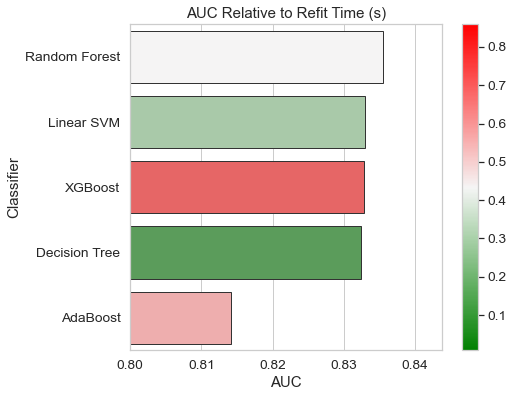

In [45]:
greenToRed = LinearSegmentedColormap.from_list('', ['green', 'whitesmoke', 'red'])
cm.register_cmap('green_to_red', greenToRed)

normRTs = plt.Normalize(results['Refit Time'].min(), results['Refit Time'].max())
smRTs = plt.cm.ScalarMappable(cmap = 'green_to_red', norm = normRTs)

ax = sns.barplot(y = 'Classifier', 
                 x = 'AUC', 
                 hue = 'Refit Time', 
                 dodge = False, 
                 palette = 'green_to_red', 
                 edgecolor = '.2', 
                 data = results)

ax.get_legend().remove()
ax.figure.colorbar(smRTs)
ax.set(title = 'AUC Relative to Refit Time (s)')
ax.set(xlim = (math.floor(results.AUC.min() * 10) * 10/100, 
               results.AUC.max() * 1.01))

plt.show()

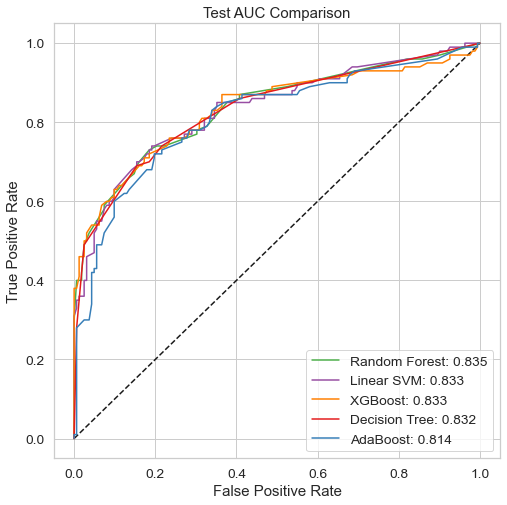

In [46]:
def Custom_ROC_Plot (results, X_test, y_test, title):

    fig, ax = plt.subplots(figsize = (8, 8))

    ax.plot(ax.get_xlim(), ax.get_ylim(), ls = '--', c = 'k')
    ax.set(title = title)

    for i in results.index:
        plot_roc_curve(models[i], 
                       X_test, 
                       y_test, 
                       color = cm.Set1(i), 
                       label = results.loc[i, 'Classifier'] + ': ' + str(round(results.loc[i, 'AUC'], 3)), 
                       ax = ax)
        
    return([fig, ax])

fig, ax = Custom_ROC_Plot(results, X_test, y_test, title = 'Test AUC Comparison')

In [47]:
best_index = results.index[0]

In [48]:
models[best_index].best_estimator_

RandomForestClassifier(max_depth=3, max_features='sqrt', n_estimators=20,
                       random_state=345)

If desired, we can also pull up some additional details regarding our model tuning process (e.g., to see how different parameters performed during the tuning process):

In [49]:
tuning_results = pd.DataFrame(models[best_index].cv_results_).sort_values('rank_test_score')

round(tuning_results, 3).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
17,0.398,0.116,0.056,0.018,3,sqrt,20,"{'max_depth': 3, 'max_features': 'sqrt', 'n_es...",0.862,0.775,0.788,0.775,0.719,0.784,0.046,1
22,0.657,0.109,0.053,0.012,3,log2,50,"{'max_depth': 3, 'max_features': 'log2', 'n_es...",0.862,0.775,0.788,0.775,0.719,0.784,0.046,1
21,0.332,0.091,0.042,0.016,3,log2,20,"{'max_depth': 3, 'max_features': 'log2', 'n_es...",0.862,0.775,0.788,0.775,0.719,0.784,0.046,1
18,0.718,0.180,0.066,0.020,3,sqrt,50,"{'max_depth': 3, 'max_features': 'sqrt', 'n_es...",0.862,0.775,0.788,0.775,0.719,0.784,0.046,1
20,0.178,0.075,0.032,0.008,3,log2,10,"{'max_depth': 3, 'max_features': 'log2', 'n_es...",0.862,0.769,0.788,0.775,0.719,0.782,0.046,5


In [50]:
len(tuning_results)

36

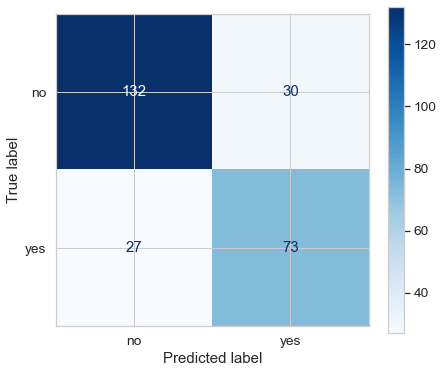

In [51]:
plot_confusion_matrix(models[best_index], 
                      X_test, 
                      y_test,
                      cmap = plt.cm.Blues,
                      values_format = 'd')

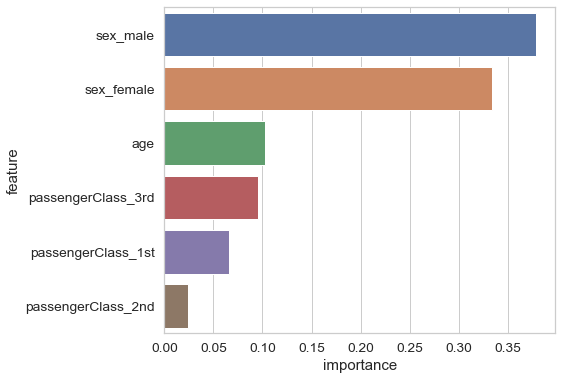

In [52]:
# for models with feature importances
if hasattr(models[best_index].best_estimator_, 'feature_importances_'):
    var_imp = pd.DataFrame({
        'feature': X_test.columns, 
        'importance': models[best_index].best_estimator_.feature_importances_}).sort_values('importance', ascending = False)
# for models with coefficients (directional)
elif hasattr(models[best_index].best_estimator_, 'coef_'):
    var_imp = pd.DataFrame({
        'feature': X_test.columns, 
        'importance_abs': abs(models[best_index].best_estimator_.coef_[0]), 
        'importance': models[best_index].best_estimator_.coef_[0]}).sort_values('importance_abs', ascending = False)
    
sns.barplot(y = 'feature', 
            x = 'importance', 
            data = var_imp.head(10))